# Viam Anomaly Detector Jupyter Training Script

## Prerequisits

In [1]:
# Install required packages

!pip3 install -r requirements.txt

In [2]:
# Imports

import numpy as np
from onnx import ModelProto

import pandas as pd

from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.ensemble import IsolationForest

import os
import bson
from dotenv import load_dotenv
from viam.app.viam_client import ViamClient
from viam.rpc.dial import DialOptions
import logging



## Script Configuration 

In [3]:
# Set up / config
load_dotenv()
model_name = "isolation_forest.onnx"
data_file = "data.csv"


## Functions

In [4]:
# Get data from app.viam.com


async def connect() -> ViamClient:
    """Connect to the VIAM cloud api"""
    dial_options = DialOptions.with_api_key(
        api_key=os.environ.get("API_KEY"), api_key_id=os.environ.get("API_KEY_ID")
    )
    return await ViamClient.create_from_dial_options(dial_options)


async def download(limit: int = 10000):
    """Download the training data"""
    logging.info("Downloading data...")
    viam_client = await connect()
    data_client = viam_client.data_client

    # Query the data set using MongoDB Query Language (MQL)
    tabular_data = await data_client.tabular_data_by_mql(
        organization_id="96b696a0-51b9-403b-ae0d-63753923652f",  # os.getenv("ORGANIZATION_ID"),
        # The MQL aggregation pipeline extract and preprocess the data
        # TODO: Set this to suit your data! https://www.mongodb.com/docs/manual/core/aggregation-pipeline/
        mql_binary=[
            bson.dumps(
                {
                    "$match": {
                        "component_name": "fake-sensor",
                    }
                }
            ),
            bson.dumps(
                {
                    "$project": {
                        "timestamp": {"$dateToString": {"date": "$time_received"}},
                        "value": "$data.readings.a",
                    }
                }
            ),
            bson.dumps({"$limit": limit}),
        ],
    )
    df = pd.DataFrame(tabular_data)
    # TODO: timestamp conversion shouldn't be necessary once the Viam SDK date type in the MQL API is fixed
    # Also remove above in the MQL pipeline
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    viam_client.close()
    logging.info(f"{len(df)} reading(s) downloaded")
    return df


In [5]:
# Save to CSV

def save_to_csv(tabular_data):
    df = pd.DataFrame(tabular_data)
    df.to_csv(data_file, index=False)

In [6]:
# Load from CSV

def loadCSV():
    print("Loading CSV...")
    df = pd.read_csv(data_file, parse_dates=["timestamp"])
    print("CSV Loaded")
    return df

In [7]:
# Feature Engineering


def featureEng(df: pd.DataFrame):
    logging.info("Feature Engineering...")

    # A variety of resamples which I may or may not use
    # TODO: Push down to the backend -> Agg. pipeline
    # df_sampled = df.set_index("timestamp").resample("min").mean().reset_index()
    # df_sampled = df.set_index("timestamp").resample("h").mean().reset_index()
    # df_sampled = df.set_index("timestamp").resample("D").mean().reset_index()
    # df_sampled = df.set_index("timestamp").resample("W").mean().reset_index()

    # Calculate the rolling mean and lag (weekdays are not used in the model)
    for DataFrame in [df_sampled]:
        DataFrame["Weekday"] = pd.Categorical(
            DataFrame["timestamp"].dt.strftime("%A"),
            categories=[
                "Monday",
                "Tuesday",
                "Wednesday",
                "Thursday",
                "Friday",
                "Saturday",
                "Sunday",
            ],
        )
        DataFrame["Hour"] = DataFrame["timestamp"].dt.hour
        DataFrame["Day"] = DataFrame["timestamp"].dt.weekday
        DataFrame["Month"] = DataFrame["timestamp"].dt.month
        DataFrame["Year"] = DataFrame["timestamp"].dt.year
        DataFrame["Month_day"] = DataFrame["timestamp"].dt.day
        DataFrame["Lag"] = DataFrame["value"].shift(1)
        DataFrame["Rolling_Mean"] = DataFrame["value"].rolling(3, min_periods=1).mean()
        DataFrame = DataFrame.dropna()
    logging.info("Feature Engineering Completed")
    return df_sampled



In [8]:
# Model Training


def fit_isolation_forest(
    model_data: pd.DataFrame,
) -> ModelProto:
    logging.info("Fitting Isolation Forest...")
    model_data = (
        model_data[
            [
                "value",
                "Hour",
                "Day",
                "Month_day",
                "Month",
                "Rolling_Mean",
                "Lag",
                "timestamp",
            ]
        ]
        .set_index("timestamp")
        .dropna()
    )

    IF = IsolationForest(
        # Parameter tuning:
        # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest
        random_state=0,
        contamination="auto",
        n_estimators=100,
        max_samples="auto",
    )

    IF.fit(model_data)

    onx = to_onnx(
        IF,
        model_data.to_numpy().astype(np.float32),
        target_opset={"": 15, "ai.onnx.ml": 3},
        initial_types=[("observation", FloatTensorType([None, 7]))],
        final_types=[
            ("label", FloatTensorType([None, 1])),
            ("scores", FloatTensorType([None, 1])),
        ],
    )
    return onx


In [9]:
# Model inference for validation purposes

# https://onnxruntime.ai/docs/api/python/tutorial.html

from onnxruntime import InferenceSession, get_available_providers

def inference(df: pd.DataFrame):
    print("Inference...")
    model_data = (
        df[
            [
                "value",
                "Hour",
                "Day",
                "Month_day",
                "Month",
                "Rolling_Mean",
                "Lag",
                "timestamp",
            ]
        ]
        .set_index("timestamp")
        .dropna()
    )

    ort_sess = InferenceSession(
        model_name,
        providers=get_available_providers(),
    )

    nparray = model_data.to_numpy(dtype=np.float32)

    input_name = ort_sess.get_inputs()[0].name
    output_name = ort_sess.get_outputs()[0].name
    print("Input Name:", input_name)
    print("Output Name:", output_name)

    pred_onx = ort_sess.run(None, {input_name: nparray})

    inference = pd.DataFrame(
        np.column_stack([pred_onx[0], pred_onx[1]]), columns=["outlier", "score"]
    )
    print("Inference Completed")
    return inference

## Script Execution

In [22]:
# Data Download
raw_data = await download()
save_to_csv(raw_data)
print(raw_data[39:])

      value                        timestamp
39      1.0 2024-07-22 14:48:28.562000+00:00
40      1.0 2024-07-22 14:48:29.562000+00:00
41      1.0 2024-07-22 14:48:30.562000+00:00
42      1.0 2024-07-22 14:48:31.562000+00:00
43      1.0 2024-07-22 14:48:32.562000+00:00
...     ...                              ...
9995    1.0 2024-07-30 16:23:38.642000+00:00
9996    1.0 2024-07-30 16:23:39.641000+00:00
9997    1.0 2024-07-30 16:23:40.642000+00:00
9998    1.0 2024-07-30 16:23:41.642000+00:00
9999    1.0 2024-07-30 16:23:42.641000+00:00

[9961 rows x 2 columns]


In [21]:
# Feature Engineering
df = featureEng(raw_data)
print(len(df))
save_to_csv(df)
df.dropna(inplace=True)
print(len(df))



11631
169


%opts magic unavailable (pyparsing cannot be imported)
%compositor magic unavailable (pyparsing cannot be imported)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
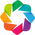

:Curve   [timestamp]   (value,Weekday,Hour,Day,Month,Year,Month_day,Lag,Rolling_Mean)

In [12]:
# Visualaize the data
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from bokeh.plotting import show

hv.Curve(df).opts(
    opts.Curve(title="Dataset Sampled (5min)", xlabel="timestamp", ylabel="value",
               width=700, height=300,tools=['hover'],show_grid=True))

In [13]:
# Value Distribution

(hv.Distribution(df['value'])
.opts(opts.Distribution(title="Overall Value Distribution",
                        xlabel="Value",
                        ylabel="Density",
                        width=700, height=300,
                        tools=['hover'],show_grid=True)
     ))

:Distribution   [value]   (Density)

In [14]:
# Distribution by day of the week

by_weekday = df.groupby(['Hour','Weekday']).mean()['value'].unstack()
plot = hv.Distribution(by_weekday['Monday'], label='Monday') * hv.Distribution(by_weekday['Tuesday'], label='Tuesday') * hv.Distribution(by_weekday['Wednesday'], label='Wednesday') * hv.Distribution(by_weekday['Thursday'], label='Thursday') * hv.Distribution(by_weekday['Friday'], label='Friday') * hv.Distribution(by_weekday['Saturday'], label='Saturday') *hv.Distribution(by_weekday['Sunday'], label='Sunday').opts(opts.Distribution(title="Demand Density by Day & Hour"))
plot.opts(opts.Distribution(width=800, height=300,tools=['hover'],show_grid=True, ylabel="value", xlabel="value"))

/var/folders/4v/blmrl3rj1js166b594btmly00000gn/T/ipykernel_49397/1407507754.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_weekday = df.groupby(['Hour','Weekday']).mean()['value'].unstack()


:Overlay
   .Distribution.Monday    :Distribution   [Monday]   (Density)
   .Distribution.Tuesday   :Distribution   [Tuesday]   (Density)
   .Distribution.Wednesday :Distribution   [Wednesday]   (Density)
   .Distribution.Thursday  :Distribution   [Thursday]   (Density)
   .Distribution.Friday    :Distribution   [Friday]   (Density)
   .Distribution.Saturday  :Distribution   [Saturday]   (Density)
   .Distribution.Sunday    :Distribution   [Sunday]   (Density)

In [16]:
# Train the model
onx = fit_isolation_forest(df)

In [17]:
# Save the model to disk
with open(model_name, "wb") as f:
    f.write(onx.SerializeToString())

In [18]:
# Validation
inf = inference(df) 
result = (df
             .assign(Outliers = inf['outlier'])
             .assign(Score = inf['score'])
            )

result[69:100]

11631
169
Inference...
Input Name: observation
Output Name: label
Inference Completed


2024-09-03 14:36:15.966158 [W:onnxruntime:, coreml_execution_provider.cc:107 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 6 number of nodes in the graph: 2513 number of nodes supported by CoreML: 1104


,timestamp,value,Weekday,Hour,Day,Month,Year,Month_day,Lag,Rolling_Mean,Outliers,Score
70,2024-07-22 15:57:00+00:00,1.0,Monday,15,0,7,2024,22,1.0,1.0,1.0,0.007491
71,2024-07-22 15:58:00+00:00,1.0,Monday,15,0,7,2024,22,1.0,1.0,-1.0,-0.045250
11380,2024-07-30 12:27:00+00:00,1.0,Tuesday,12,1,7,2024,30,1.0,1.0,NaN,NaN
11381,2024-07-30 12:28:00+00:00,1.0,Tuesday,12,1,7,2024,30,1.0,1.0,NaN,NaN
11382,2024-07-30 12:29:00+00:00,1.0,Tuesday,12,1,7,2024,30,1.0,1.0,NaN,NaN
11383,2024-07-30 12:30:00+00:00,1.0,Tuesday,12,1,7,2024,30,1.0,1.0,NaN,NaN
11384,2024-07-30 12:31:00+00:00,1.0,Tuesday,12,1,7,2024,30,1.0,1.0,NaN,NaN
11385,2024-07-30 12:32:00+00:00,1.0,Tuesday,12,1,7,2024,30,1.0,1.0,NaN,NaN
11386,2024-07-30 12:33:00+00:00,1.0,Tuesday,12,1,7,2024,30,1.0,1.0,NaN,NaN
11387,2024-07-30 12:34:00+00:00,1.0,Tuesday,12,1,7,2024,30,1.0,1.0,NaN,NaN


In [ ]:
# Display Outliers

from bokeh.models import HoverTool

tooltips = [
    ('Weekday', '@Weekday'),
    ('Day', '@Month_day'),
    ('Month', '@Month'),
    ('Value', '@value'),
    ('Average Value', '@value_Average'),
    ('Outliers', '@Outliers')
]
hover = HoverTool(tooltips=tooltips)

hv.Points(df.query("Outliers == 1")).opts(size=10, color='#ff0000') * hv.Curve(df).opts(opts.Curve(title="Anomalies", xlabel="", ylabel="Demand" , height=300, responsive=True,tools=[hover,'box_select', 'lasso_select', 'tap'],show_grid=True))